# Análisis Exploratorio de Datos de Criptomonedas

Este notebook contiene el análisis exploratorio de los datos de criptomonedas almacenados en la base de datos PostgreSQL.

## Contenido
1. Conexión a la base de datos
2. Visualización de precios de Bitcoin, Ethereum y Cardano
3. Generación de características para clasificación de riesgo
4. Análisis de tendencias y varianza

In [ ]:
%pip install psycopg2

In [10]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

# Configurar opciones de visualización para pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## 1. Conexión a la Base de Datos

Conectamos a la base de datos PostgreSQL para cargar los datos de criptomonedas.

In [11]:
# Configuración de la conexión a Postgres
DB_HOST = "localhost"  # o la IP asignada por Docker
DB_PORT = "5432"
DB_NAME = "postgres"   
DB_USER = "postgres"
DB_PASSWORD = "postgres"

# Conexión a la base de datos con psycopg2
def connect_to_database():
    try:
        conn = psycopg2.connect(
            host=DB_HOST,
            port=DB_PORT,
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD
        )
        print(f"Conexión exitosa a la base de datos {DB_NAME}")
        return conn
    except Exception as e:
        print(f"Error al conectarse a la base de datos: {e}")
        return None

# Conexión con SQLAlchemy para pandas
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

# Verificar la conexión
conn = connect_to_database()
if conn:
    print("Conexión establecida correctamente")
    conn.close()

Conexión exitosa a la base de datos postgres
Conexión establecida correctamente


### Verificación de las tablas disponibles

In [12]:
# Listar las tablas disponibles en la base de datos
conn = connect_to_database()
if conn:
    cursor = conn.cursor()
    cursor.execute("""
    SELECT table_name FROM information_schema.tables
    WHERE table_schema = 'public'
    """)
    tables = cursor.fetchall()
    print("Tablas disponibles:")
    for table in tables:
        print(f"- {table[0]}")
    
    # Verificar estructura de la tabla coin_history
    cursor.execute("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'coin_history'
    """)
    columns = cursor.fetchall()
    print("\nEstructura de la tabla coin_history:")
    for col in columns:
        print(f"- {col[0]}: {col[1]}")
    
    # Contar registros por moneda
    cursor.execute("""
    SELECT coin_id, COUNT(*) as count 
    FROM coin_history 
    GROUP BY coin_id
    """)
    counts = cursor.fetchall()
    print("\nNúmero de registros por moneda:")
    for count in counts:
        print(f"- {count[0]}: {count[1]} registros")
    
    cursor.close()
    conn.close()

Conexión exitosa a la base de datos postgres
Tablas disponibles:
- coin_history
- coin_monthly_aggregates

Estructura de la tabla coin_history:
- id: integer
- price_usd: numeric
- fetch_date: date
- response_data: jsonb
- created_at: timestamp with time zone
- coin_id: character varying

Número de registros por moneda:
- bitcoin: 111 registros
- cardano: 126 registros
- ethereum: 118 registros


## 2. Visualización de Precios de Criptomonedas

### 2.1 Carga de datos de los últimos 30 días

In [17]:
# Obtener la fecha actual y calcular la fecha de hace 30 días
today = datetime.now().date()
ultimos_30_dias = today - timedelta(days=30)

# Consulta SQL para obtener los precios de bitcoin, ethereum y cardano de los últimos 30 días
query = """
SELECT coin_id, price_usd, fetch_date
FROM coin_history
WHERE coin_id IN ('bitcoin', 'ethereum', 'cardano')
  AND fetch_date >= %s
ORDER BY coin_id, fetch_date
"""

# Cargar los datos en un DataFrame
try:
    conn = connect_to_database()
    df = pd.read_sql_query(query, conn, params=(ultimos_30_dias,))
    conn.close()
    
    print(f"Datos cargados: {len(df)} registros")
    display(df.head())
    
    # Resumen estadístico por moneda
    print("\nResumen estadístico por moneda:")
    display(df.groupby('coin_id')['price_usd'].describe())
    
except Exception as e:
    print(f"Error al cargar datos: {e}")
    
    # Plan B: si no hay suficientes datos de los últimos 30 días, cargar todos los datos disponibles
    print("\nIntentando cargar todos los datos disponibles...")
    try:
        conn = connect_to_database()
        backup_query = """
        SELECT coin_id, price_usd, fetch_date
        FROM coin_history
        WHERE coin_id IN ('bitcoin', 'ethereum', 'cardano')
        ORDER BY coin_id, fetch_date
        """
        df = pd.read_sql_query(backup_query, conn)
        conn.close()
        print(f"Datos cargados (todos los disponibles): {len(df)} registros")
        display(df.head())
    except Exception as e2:
        print(f"Error al cargar todos los datos: {e2}")

Conexión exitosa a la base de datos postgres
Datos cargados: 93 registros


,coin_id,price_usd,fetch_date
0,bitcoin,84523.452491,2025-04-15
1,bitcoin,83656.492489,2025-04-16
2,bitcoin,84105.779422,2025-04-17
3,bitcoin,84930.908576,2025-04-18
4,bitcoin,84433.750172,2025-04-19



Resumen estadístico por moneda:


,count,mean,std,min,25%,50%,75%,max
coin_id,,,,,,,,
bitcoin,31.0,94341.847778,6719.676566,83656.492489,90514.106438,94644.066371,96941.030952,104630.879299
cardano,31.0,0.700271,0.067586,0.608064,0.648951,0.697265,0.717977,0.840060
ethereum,31.0,1904.107890,340.571292,1577.446560,1690.624828,1799.501914,1840.140960,2676.639163


### 2.2 Visualización de precios

Monedas disponibles: bitcoin, cardano, ethereum


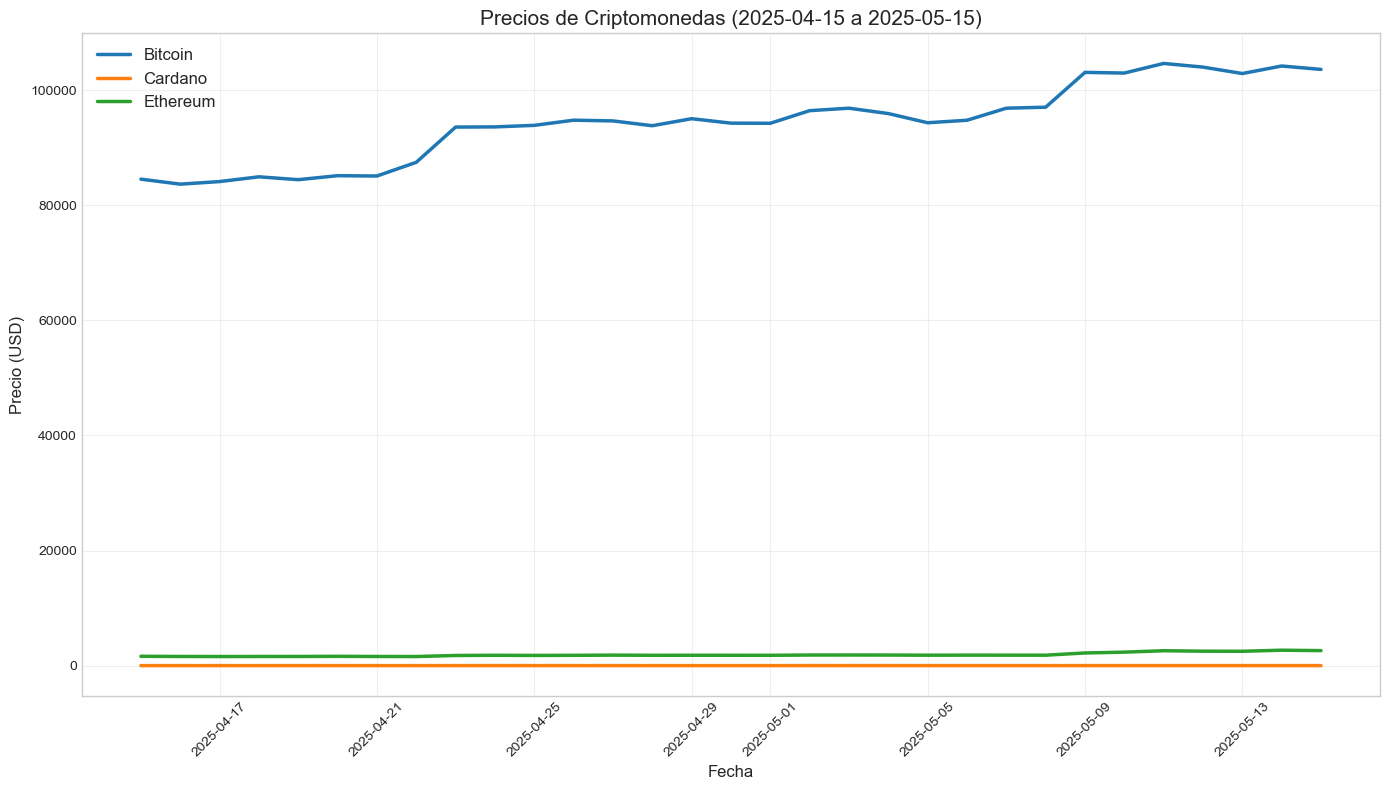

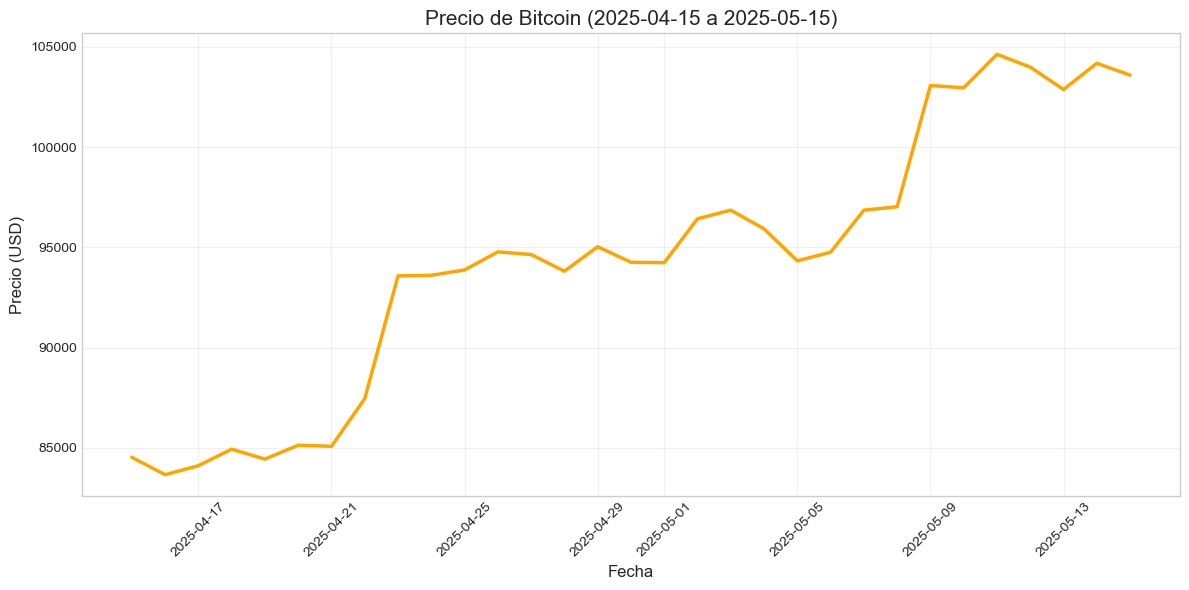

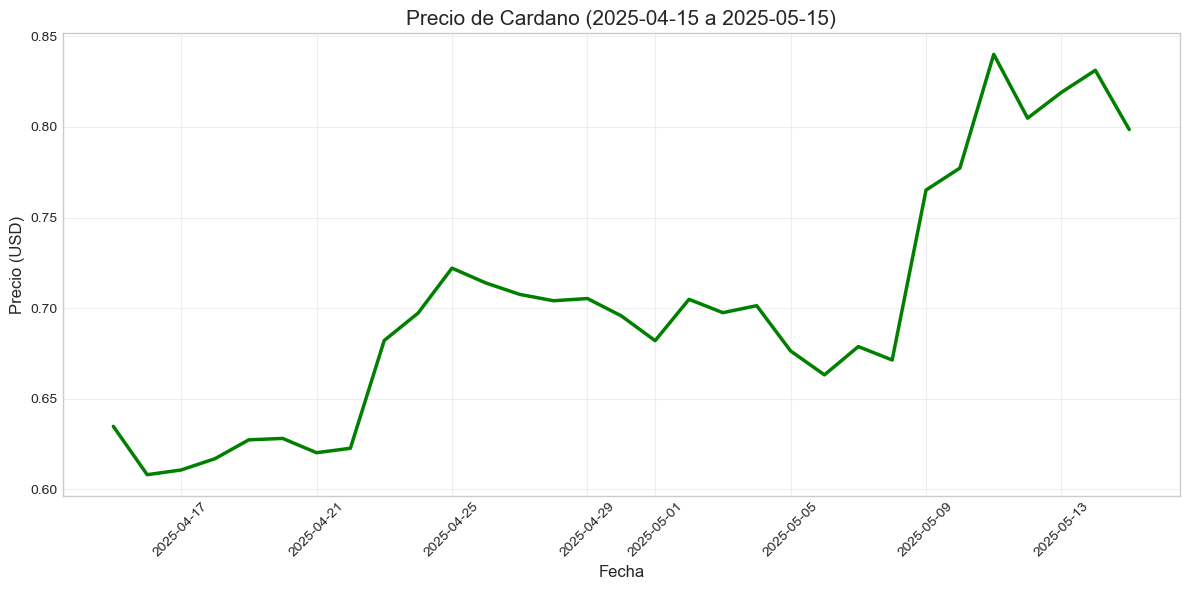

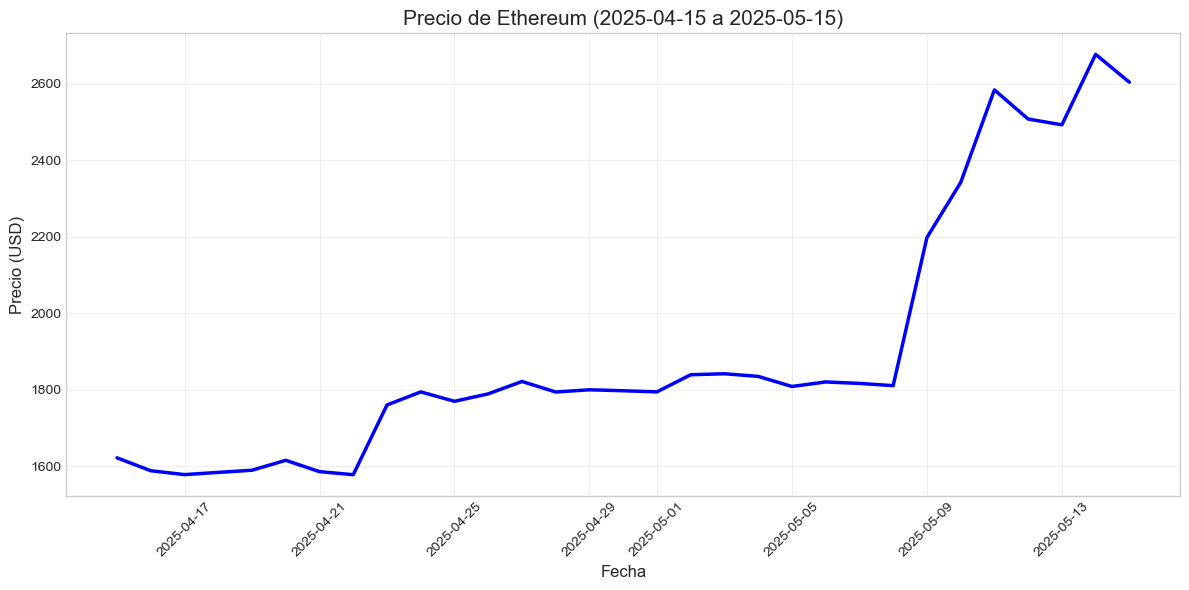

In [18]:
# Verificar si tenemos datos para las tres monedas
coins = df['coin_id'].unique()
print(f"Monedas disponibles: {', '.join(coins)}")

# Obtener la fecha de inicio y fin para el título
start_date = df['fetch_date'].min().strftime('%Y-%m-%d')
end_date = df['fetch_date'].max().strftime('%Y-%m-%d')

# Crear un pivot para facilitar la visualización
pivot_df = df.pivot(index='fetch_date', columns='coin_id', values='price_usd')

# Crear la figura para guardar
plt.figure(figsize=(14, 8))

# Graficar los precios de cada moneda
for coin in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[coin], linewidth=2.5, label=coin.capitalize())

plt.title(f'Precios de Criptomonedas ({start_date} a {end_date})', fontsize=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

# Guardar la figura
plt.tight_layout()
plt.savefig('../data/crypto_prices.png', dpi=300)
plt.show()

# También graficar cada moneda por separado para ver mejor los detalles
for coin in pivot_df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df.index, pivot_df[coin], linewidth=2.5, color={
        'bitcoin': 'orange',
        'ethereum': 'blue',
        'cardano': 'green'
    }.get(coin, 'red'))
    
    plt.title(f'Precio de {coin.capitalize()} ({start_date} a {end_date})', fontsize=15)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Precio (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Guardar la figura
    plt.tight_layout()
    plt.savefig(f'../data/{coin}_price.png', dpi=300)
    plt.show()

## 3. Generación de Características para Clasificación de Riesgo

### 3.1 Carga de todos los datos disponibles

In [ ]:
# Cargar todos los datos de precio disponibles
try:
    conn = connect_to_database()
    query_all = """
    SELECT coin_id, price_usd, fetch_date
    FROM coin_history
    ORDER BY coin_id, fetch_date
    """
    all_data = pd.read_sql_query(query_all, conn)
    conn.close()
    
    print(f"Total de registros cargados: {len(all_data)}")
    print(f"Monedas únicas: {all_data['coin_id'].nunique()}")
    print(f"Rango de fechas: {all_data['fetch_date'].min()} a {all_data['fetch_date'].max()}")
    
    # Mostrar los primeros registros
    display(all_data.head())
    
except Exception as e:
    print(f"Error al cargar todos los datos: {e}")

### 3.2 Calcular cambios porcentuales diarios

In [ ]:
# Asegurarse de que los datos estén ordenados por moneda y fecha
all_data = all_data.sort_values(['coin_id', 'fetch_date'])

# Calcular el cambio porcentual diario por cada moneda
all_data['pct_change'] = all_data.groupby('coin_id')['price_usd'].pct_change() * 100

# Mostrar los primeros resultados
print("Cambios porcentuales diarios:")
display(all_data.head(10))

# Extraer año y mes para agrupar por mes calendario
all_data['year'] = all_data['fetch_date'].dt.year
all_data['month'] = all_data['fetch_date'].dt.month
all_data['year_month'] = all_data['fetch_date'].dt.strftime('%Y-%m')

### 3.3 Definir tipos de riesgo

Clasificaremos las monedas en:
- "High Risk": si tuvo una caída del 50% en cualquier dos días consecutivos durante un mes calendario
- "Medium Risk": si tuvo una caída de más del 20% en dos días consecutivos durante un mes calendario
- "Low Risk": para el resto

In [ ]:
def calculate_risk_level(group):
    # Crear una columna con el cambio porcentual del día siguiente
    group = group.sort_values('fetch_date')
    group['next_day_pct_change'] = group['pct_change'].shift(-1)
    
    # Buscar caídas consecutivas
    high_risk = False
    medium_risk = False
    
    # Verificar caídas consecutivas (ambos días con cambio negativo)
    two_day_drops = (group['pct_change'] < 0) & (group['next_day_pct_change'] < 0)
    if two_day_drops.any():
        # Calcular la caída acumulada en dos días
        for i in range(len(group) - 1):
            if group['pct_change'].iloc[i] < 0 and group['pct_change'].iloc[i+1] < 0:
                # Calcular el cambio acumulado (multiplicativo, no aditivo)
                day1_change = group['pct_change'].iloc[i] / 100  # convertir a decimal
                day2_change = group['pct_change'].iloc[i+1] / 100  # convertir a decimal
                two_day_change = ((1 + day1_change) * (1 + day2_change) - 1) * 100
                
                if two_day_change <= -50:  # caída del 50% o más
                    high_risk = True
                    break
                elif two_day_change <= -20:  # caída del 20% o más
                    medium_risk = True
    
    if high_risk:
        return "High Risk"
    elif medium_risk:
        return "Medium Risk"
    else:
        return "Low Risk"

# Calcular el nivel de riesgo por moneda y mes
risk_levels = all_data.groupby(['coin_id', 'year_month']).apply(calculate_risk_level).reset_index()
risk_levels.columns = ['coin_id', 'year_month', 'risk_level']

# Mostrar los resultados
print("Niveles de riesgo por moneda y mes:")
display(risk_levels)

### 3.4 Unir el nivel de riesgo a los datos originales

In [ ]:
# Unir la información de riesgo con los datos originales
all_data = all_data.merge(risk_levels, on=['coin_id', 'year_month'], how='left')

# Mostrar los resultados
print("Datos con niveles de riesgo:")
display(all_data.head())

# Visualizar la distribución de los niveles de riesgo por moneda
risk_distribution = all_data.groupby(['coin_id', 'risk_level']).size().unstack().fillna(0)
risk_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Niveles de Riesgo por Moneda', fontsize=14)
plt.xlabel('Moneda', fontsize=12)
plt.ylabel('Número de Días', fontsize=12)
plt.legend(title='Nivel de Riesgo')
plt.tight_layout()
plt.savefig('../data/risk_distribution.png', dpi=300)
plt.show()

## 4. Análisis de Tendencias y Varianza

### 4.1 Calcular tendencia y varianza de los últimos 7 días

In [ ]:
def calculate_trend_and_variance(group):
    # Ordenar por fecha
    group = group.sort_values('fetch_date')
    
    # Crear columnas para la tendencia y varianza
    group['rolling_7d_trend'] = float('nan')
    group['rolling_7d_variance'] = float('nan')
    
    # Necesitamos al menos 8 días de datos (T0 vs T-1 hasta T-7)
    if len(group) >= 8:
        for i in range(7, len(group)):
            # Obtener los precios de los 8 días (T-7 hasta T0)
            prices = group['price_usd'].iloc[i-7:i+1].values
            
            # Calcular la tendencia (T0 vs T-7)
            t0_price = prices[-1]
            t7_price = prices[0]
            trend = ((t0_price / t7_price) - 1) * 100  # cambio porcentual
            
            # Calcular la varianza
            variance = np.var(prices)
            
            # Asignar los valores calculados
            group['rolling_7d_trend'].iloc[i] = trend
            group['rolling_7d_variance'].iloc[i] = variance
    
    return group

# Aplicar la función a cada grupo de moneda
all_data = all_data.groupby('coin_id').apply(calculate_trend_and_variance).reset_index(drop=True)

# Mostrar los resultados
print("Datos con tendencia y varianza de 7 días:")
display(all_data.head(10))

### 4.2 Visualizar la tendencia y varianza

In [ ]:
# Filtrar las filas con datos completos (sin NaN)
trend_data = all_data.dropna(subset=['rolling_7d_trend', 'rolling_7d_variance'])

# Graficar la tendencia de 7 días para cada moneda
plt.figure(figsize=(14, 8))

for coin in trend_data['coin_id'].unique():
    coin_data = trend_data[trend_data['coin_id'] == coin]
    plt.plot(coin_data['fetch_date'], coin_data['rolling_7d_trend'], label=coin.capitalize(), linewidth=2.5)

plt.title('Tendencia de 7 días por Moneda', fontsize=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cambio Porcentual (%)', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)  # Línea horizontal en 0%
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

# Guardar la figura
plt.tight_layout()
plt.savefig('../data/7d_trend.png', dpi=300)
plt.show()

# Graficar la varianza de 7 días para cada moneda
plt.figure(figsize=(14, 8))

for coin in trend_data['coin_id'].unique():
    coin_data = trend_data[trend_data['coin_id'] == coin]
    plt.plot(coin_data['fetch_date'], coin_data['rolling_7d_variance'], label=coin.capitalize(), linewidth=2.5)

plt.title('Varianza de Precios de 7 días por Moneda', fontsize=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Varianza', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

# Guardar la figura en escala logarítmica para mejor visualización
plt.yscale('log')
plt.tight_layout()
plt.savefig('../data/7d_variance.png', dpi=300)
plt.show()

## 5. Guardar los Datos Procesados para Uso Futuro

Guardamos el DataFrame resultante para usarlo en el notebook de predicciones.

In [ ]:
# Guardar los datos procesados
all_data.to_csv('../data/processed_crypto_data.csv', index=False)
print(f"Datos procesados guardados en '../data/processed_crypto_data.csv'")

# Resumen final
print("\nResumen de los datos procesados:")
print(f"Total de filas: {len(all_data)}")
print(f"Columnas: {', '.join(all_data.columns.tolist())}")
print(f"Monedas: {', '.join(all_data['coin_id'].unique())}")
print(f"Niveles de riesgo encontrados: {', '.join(all_data['risk_level'].unique())}")
print(f"Porcentaje de datos con tendencia y varianza: {(len(trend_data) / len(all_data)) * 100:.2f}%")